Uploading data

In [ ]:
# imports
from google.colab import files
import pandas as pd
import numpy as np
import io
import os
import zipfile

In [ ]:
# upload files
steering_value_upload = files.upload()

Saving steer_values.txt to steer_values.txt


In [ ]:
# upload image zip file (10k images)
images_upload = files.upload()

Saving 10kimages.zip to 10kimages.zip


In [ ]:
# make image directory
image_root_path = 'images/road'
if not os.path.exists(image_root_path):
  os.makedirs(image_root_path)

In [ ]:
# extract the images
zip_ref = zipfile.ZipFile('10kimages.zip', 'r')
zip_ref.extractall(image_root_path)
zip_ref.close()

In [ ]:
# code to parse the steering value

steer_value_path = 'steer_values.txt'
sample_size = 10001
steer_values = np.zeros(sample_size)

# read the steering value strings, convert it to float,
# and multiply it by 1000 to make it easier to comprehend
with open(steer_value_path, 'r') as f:
    lines = f.read().split('\n')
    steer_values = lines[:sample_size]
    steer_values = [float(i)*1000 for i in steer_values]
    print(steer_values)

[-3.0801170505583286, -3.916697110980749, -2.3106466978788376, 1.6234726645052433, 4.178800620138645, 6.573832593858242, 20.388931035995483, 52.66948044300079, 98.45584630966187, 157.03243017196655, 218.70151162147522, 287.89734840393066, 312.43303418159485, 356.4627766609192, 374.2963671684265, 379.0881633758545, 394.3110406398773, 369.50382590293884, 378.6929249763489, 383.21223855018616, 374.10834431648254, 369.1583275794983, 372.8930354118347, 382.9510807991028, 369.70439553260803, 343.7964916229248, 348.18780422210693, 297.26243019104004, 316.0009980201721, 293.7391698360443, 272.74173498153687, 238.91863226890564, 248.3285367488861, 240.6129091978073, 228.5231351852417, 196.66120409965515, 207.63735473155975, 171.012282371521, 56.4723014831543, 73.77094030380249, 14.428898692131042, 13.7709379196167, -9.561508893966675, -27.03733742237091, -28.938382863998413, -28.24154496192932, -32.609209418296814, -30.777066946029663, -28.494104743003845, -26.170969009399414, -20.9473073482513

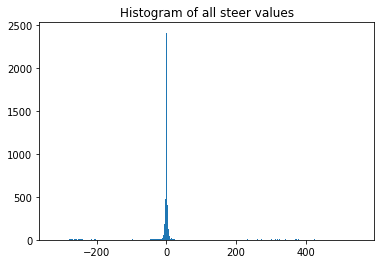

In [ ]:
import matplotlib.pyplot as plt
plt.hist(steer_values, bins=np.arange(-320,553,1))
plt.title("Histogram of all steer values")
plt.show()

In [ ]:
len([i for i in steer_values if -1 < i < 1])

3902

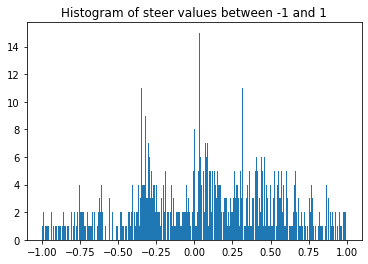

In [ ]:
plt.hist([i for i in steer_values if -1 < i < 1], bins=np.arange(-1,1,0.001))
plt.title("Histogram of steer values between -1 and 1")
plt.show()

In [ ]:
# reading images method

import os
import matplotlib.pyplot as plt
from PIL import Image

def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(image_root_path)):
        # TODO i don't need alpha channel
        img = Image.open(os.path.join(folder,filename))
        img =img.resize((np.array(img.size)/2).astype(int))
        img = np.asarray(img)
        if img is not None:
            images.append(img)
    return images

In [ ]:
# images
images = load_images_from_folder(image_root_path)

In [ ]:
# get image shape for test
print(images[0].shape)

(110, 110, 4)


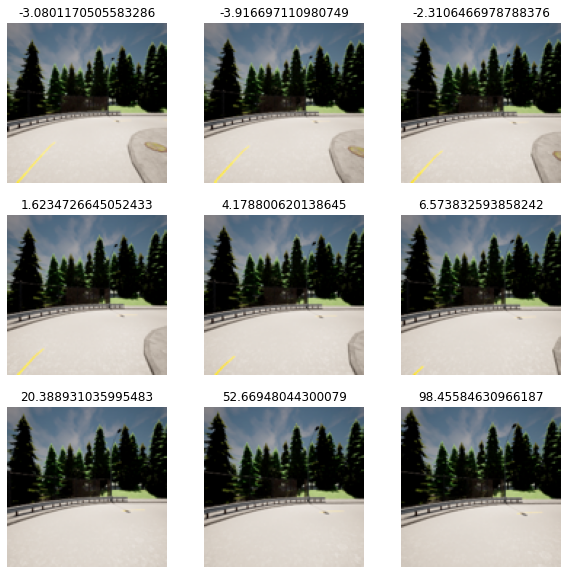

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    # first 9 images and steering values
    plt.imshow(images[i])
    plt.title(steer_values[i])

    plt.axis("off")

Model and training

In [ ]:
# model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [ ]:
# to add more variation in data
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [ ]:

min = np.min(steer_values)
max = np.max(steer_values)

def NormalizeData(data):
    return (data - min) / (max - min)

steer_values = map(NormalizeData, steer_values)
steer_values = np.array(list(steer_values))


In [ ]:
steer_values

array([0.34325348, 0.34234987, 0.34408461, ..., 0.34704468, 0.34670036,
       0.34632055])

In [ ]:

# pixel normalization
from numpy import asarray

# from 0-255 to 0-1
def normalize_color(image):
  pixels = asarray(image)
  # convert from integers to floats
  pixels = pixels.astype('float32')
  # normalize to the range 0-1
  pixels /= 255.0
  return pixels

images = map(normalize_color, images)
images = np.array(list(images))


In [ ]:
# print(np.delete(images[0],slice(0, 55), axis=0).shape)

In [ ]:
print(images.dtype)

float32


In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, steer_values, test_size=0.2, random_state=42)


In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers import Lambda, Cropping2D

image_size = 110

# cut the top half
image_top_crop = 55

model = Sequential()

# Preprocess incoming data, centered around zero with small standard deviation
# model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(image_size,image_size,3)))

# trim image to only see section with road
# model.add(Cropping2D(cropping=((image_top_crop,0),(0,0))))

#layer 1- Convolution, no of filters- 24, filter size= 5x5, stride= 2x2
model.add(Convolution2D(24,kernel_size=(5,5),strides=(2,2), activation='elu',
          input_shape=(image_size,image_size,4)))

#layer 2- Convolution, no of filters- 36, filter size= 5x5, stride= 2x2
model.add(Convolution2D(36,kernel_size=(5,5),strides=(2,2), activation='elu'))

#layer 3- Convolution, no of filters- 48, filter size= 5x5, stride= 2x2
model.add(Convolution2D(48,kernel_size=(5,5),strides=(2,2), activation='elu'))

#layer 4- Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
model.add(Convolution2D(64,kernel_size=(3,3), activation='elu'))

#layer 5- Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
model.add(Convolution2D(64,kernel_size=(3,3), activation='elu'))

#Adding a dropout layer to avoid overfitting.
#Here we are have given the dropout rate as 25% after first fully connected layer
model.add(Dropout(0.25))

#flatten image from 2D to side by side
model.add(Flatten())
#layer 6- fully connected layer 1
model.add(Dense(100, activation='elu'))
#layer 7- fully connected layer 1
model.add(Dense(50, activation='elu'))
#layer 8- fully connected layer 1
model.add(Dense(10, activation='elu'))
#layer 9- fully connected layer 1
model.add(Dense(1)) #here the final layer will contain one value as this is a regression problem and not classification



In [ ]:
model.compile(loss="mse",
              optimizer="adam")

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size = 32,
    # callbacks=callbacks,
    validation_data=(X_val, y_val)
)

Epoch 1/30
250/250 [==============================] - 76s 295ms/step - loss: 0.3349 - val_loss: 0.0082
Epoch 2/30
250/250 [==============================] - 66s 265ms/step - loss: 0.0100 - val_loss: 0.0072
Epoch 3/30
250/250 [==============================] - 67s 267ms/step - loss: 0.0085 - val_loss: 0.0080
Epoch 4/30
250/250 [==============================] - 67s 268ms/step - loss: 0.0079 - val_loss: 0.0065
Epoch 5/30
250/250 [==============================] - 66s 266ms/step - loss: 0.0072 - val_loss: 0.0062
Epoch 6/30
250/250 [==============================] - 67s 268ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 7/30
250/250 [==============================] - 67s 267ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 8/30
250/250 [==============================] - 68s 271ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 9/30
250/250 [==============================] - 87s 349ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 10/30
250/250 [==============================] - 72s 290ms/step - l

In [ ]:
# save model
model.save('my_model')

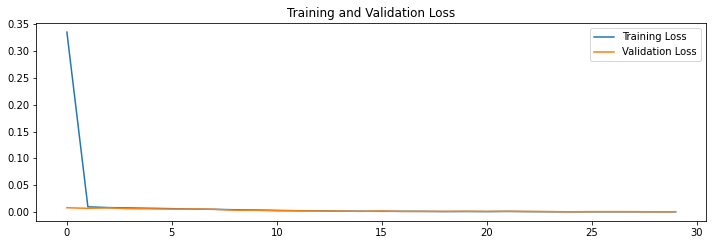

In [ ]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

range(0, 28)


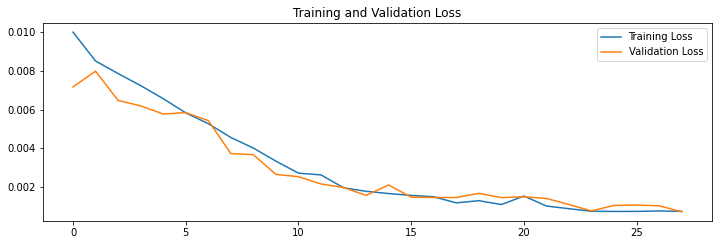

In [ ]:
length = len(loss)
loss = history.history['loss'][1:length+1]
val_loss = history.history['val_loss'][1:length+1]
epochs_range = range(len(loss))
print(epochs_range)
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()